In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# 設置中文字體
font_path = r'C:\Windows\Fonts\simsun.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 指定模型名称
model_name = r'E:\jupyter_notebook\语义检索\siku-bert'

# 加載tokenizer和model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of BertModel were not initialized from the model checkpoint at E:\jupyter_notebook\语义检索\siku-bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
def get_embeddings(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=20, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    embeddings = output.last_hidden_state[:, 0, :]
    return embeddings.numpy()

In [3]:
input_path = r'F:\古籍處理數據\input\方言篇\方言篇詞彙.xlsx'
df = pd.read_excel(input_path)

# 獲取詞向量
embeddings = get_embeddings(df['通語'].tolist())

In [113]:
# 使用DBSCAN聚類
dbscan = DBSCAN(eps=5, min_samples=3)
clusters = dbscan.fit_predict(embeddings)

# 使用t-SNE降維
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# 將聚類結果添加到df
df['類別'] = clusters

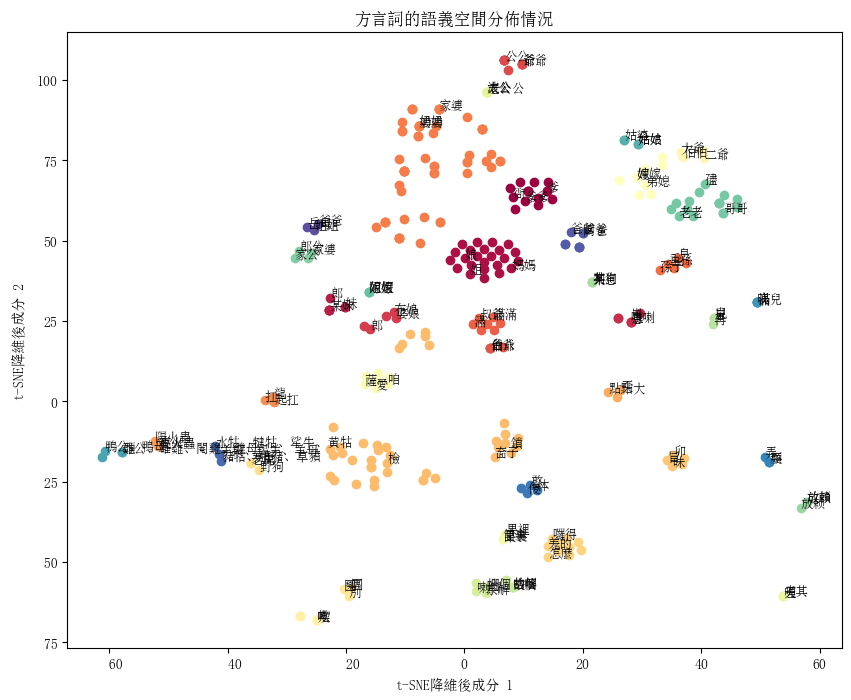

In [107]:
# 爲每個類生成不同顏色
unique_clusters = set(clusters)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters) - 1))  # 減去不相關的-1類

plt.figure(figsize=(10, 8))
label_counts = {label: 0 for label in unique_clusters if label != -1}
used_labels_per_cluster = {label: set() for label in unique_clusters if label != -1}  # 為每個類別創建一個集合來跟蹤已經使用過的標簽

for i, (label, x, y) in enumerate(zip(clusters, embeddings_2d[:, 0], embeddings_2d[:, 1])):
    if label != -1:
        color = colors[label]
        plt.scatter(x, y, color=color, alpha=1)
        # 衹爲每個類的前3個數據點添加標簽
        if label_counts[label] < 3:
            dialect_word = df['方言'][i]
            # 確保標籤不重複
            if dialect_word not in used_labels_per_cluster[label]:
                plt.text(x, y, dialect_word, fontsize=9)
                used_labels_per_cluster[label].add(dialect_word)  # 將標簽添加到已使用集合中
            label_counts[label] += 1

plt.title('方言詞的語義空間分佈情況')
plt.xlabel('t-SNE降維後成分 1')
plt.ylabel('t-SNE降維後成分 2')
plt.show()

# 导出包含聚类结果的DataFrame到新的Excel文件
output_path = r'F:\古籍處理數據\input\clusters.xlsx'
df.to_excel(output_path, index=False)